# Compute Rolling Standard Deviation, and Slope, and Output Thresholded Polygons

In [1]:
import rasterio as rio
from rasterio import features
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import numpy.ma as ma
import os
import geopandas as gpd
import pandas as pd
from rasterio.plot import plotting_extent

from geopandas import GeoDataFrame
from shapely.geometry import shape

In [2]:
fn = 'data/TM_subset_final.tif'

In [3]:
im = xr.open_rasterio(fn)

In [4]:
#im_subset = im[:,0:511,0:511]

## Compute the Rolling Standard Deviation

In [5]:
# This function computes the rolling standard deviation within a square window of
# dimensions 'size' x 'size' and outputs a new array the standard deviation as the attribute values

def rolling_stdev(im, size):
    r = im.rolling(y=size)                    # this creates the xarray Rolling object 
    im_stdev = r.reduce(np.std)
    return im_stdev

In [6]:
# Implement the rolling standard deviation function on the image

#%%timeit
stdev = rolling_stdev(im, 12)

In [7]:
# Get rid of the third dimension

stdev = stdev.squeeze()
stdev.shape

(5000, 5000)

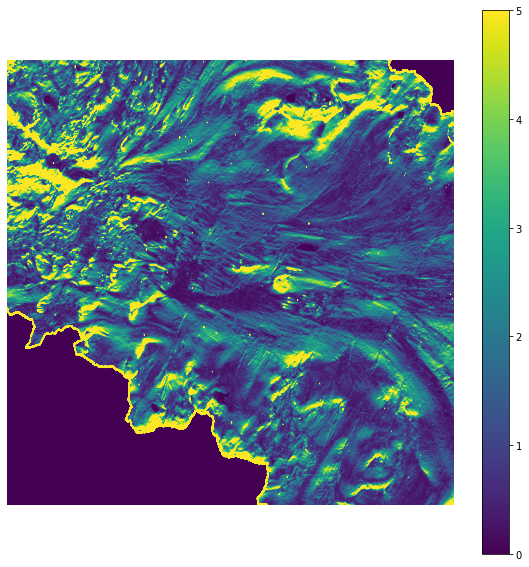

In [8]:
fig, ax = plt.subplots(figsize=(10,10)) 
c=ax.imshow(stdev, vmin=0, vmax=5)           
ax.axis('off')
plt.colorbar(c)

## Threshold the Standard Deviation and Create Polygons from this Data

In [9]:
# Code in this cell is adapted from David Shean, supplied via Slack in March 2021
# This code masks the values of a raster above a certain value, 
# and outputs polygons for the masked and unmasked areas above a certain area threshold.

stdev_feat_list = []
ovr_scale = 5
src = rio.open(fn) 
x = stdev.coarsen(x=5).mean().coarsen(y=5).mean()
a = ma.masked_invalid(x, copy=True)
#a = stdev.read(1, masked=True, out_shape=(stdev.count, int(stdev.height / ovr_scale), int(stdev.width / ovr_scale)))
ovr_transform = src.transform * src.transform.scale(src.width / x.shape[-1], src.height / x.shape[-2])
b = ma.masked_where(a > 1, a)
mask = np.ma.getmaskarray(b).astype(np.uint8) - 1
shapes = features.shapes(mask, mask=mask, transform=ovr_transform)
geom_list = list(shapes)
dt = os.path.splitext(os.path.split(fn)[-1])[0].split('_')[-1]
stdev_feat_list.extend([{'properties':{'stdev':fn, 'date':dt}, 'geometry':i[0]} for i in geom_list])
stdev_gdf = gpd.GeoDataFrame.from_features(stdev_feat_list, crs=src.crs)
#remove tiny polygons
area_thresh = 1e5
stdev_gdf = stdev_gdf.loc[stdev_gdf.area > area_thresh]
#Shoud simplify and sieve

In [10]:
stdev_gdf.head()

,geometry,stdev,date
280,"POLYGON ((288237.000 4202637.000, 288237.000 4...",data/TM_subset_final.tif,final
393,"POLYGON ((293307.000 4202592.000, 293307.000 4...",data/TM_subset_final.tif,final
440,"POLYGON ((290457.000 4202637.000, 290457.000 4...",data/TM_subset_final.tif,final
767,"POLYGON ((285612.000 4202142.000, 285612.000 4...",data/TM_subset_final.tif,final
985,"POLYGON ((287967.000 4202637.000, 287967.000 4...",data/TM_subset_final.tif,final


<AxesSubplot:>

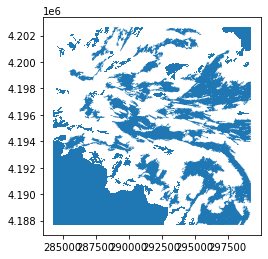

In [11]:
stdev_gdf.plot()

## Compute the Slope (or at least Load in the Data)

In [12]:
# Only run this cell is you don't already have a slope raster. 
# If you already have a slope raster, load it in in cells below.

# slope_fn = 'data/slope_final.tif'
# !gdaldem slope $fn $slope_fn

In [15]:
slope_fn = '/Users/Hannah/Documents/Documents_Grad/Research/GDA_2021/ImageAnalysis/data/slope_final.tif'

## Create Slope Threshold Polygons

In [16]:
# Code in this cell is from David Shean, supplied via Slack in March 2021
# This code masks the values of a raster above a certain value, 
# and outputs polygons for the masked and unmasked areas above a certain area threshold.

slp_feat_list = []
ovr_scale = 8
src1 = rio.open(slope_fn)
c = src1.read(1, masked=True, out_shape=(src1.count, int(src1.height / ovr_scale), int(src1.width / ovr_scale)))
c = ma.masked_invalid(c, copy=True)
ovr1_transform = src1.transform * src1.transform.scale(src1.width / c.shape[-1], src1.height / c.shape[-2])
d = ma.masked_where(c > 15, c)
mask1 = np.ma.getmaskarray(d).astype(np.uint8) - 1
shapes1 = features.shapes(mask1, mask=mask1, transform=ovr1_transform)
geom_list1 = list(shapes1)
dt = os.path.splitext(os.path.split(fn)[-1])[0].split('_')[-1]
slp_feat_list.extend([{'properties':{'fn':fn, 'date':dt}, 'geometry':i[0]} for i in geom_list1])
slp_gdf = gpd.GeoDataFrame.from_features(slp_feat_list, crs=src1.crs)
#remove tiny polygons
area_thresh = 1e5
slp_gdf = slp_gdf.loc[slp_gdf.area > area_thresh]
#Shoud simplify and sieve

In [17]:
slp_gdf.head()

,geometry,fn,date
365,"POLYGON ((286455.000 4202523.000, 286455.000 4...",data/TM_subset_final.tif,final
499,"POLYGON ((294183.000 4202667.000, 294183.000 4...",data/TM_subset_final.tif,final
532,"POLYGON ((290991.000 4202667.000, 290991.000 4...",data/TM_subset_final.tif,final
793,"POLYGON ((284655.000 4202283.000, 284655.000 4...",data/TM_subset_final.tif,final
862,"POLYGON ((295359.000 4201875.000, 295359.000 4...",data/TM_subset_final.tif,final


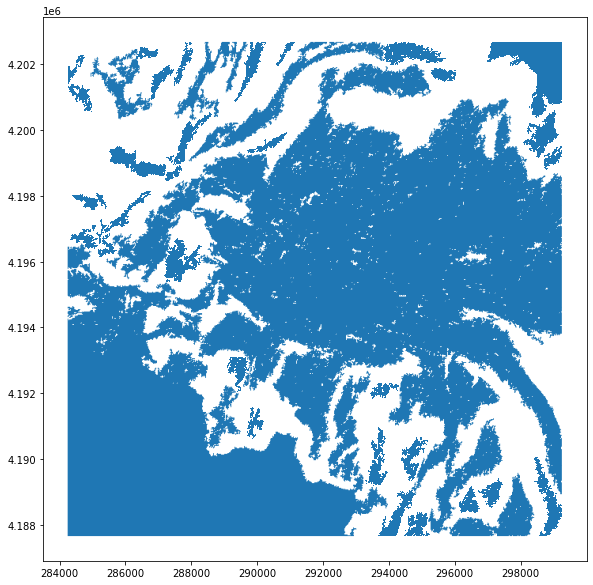

In [18]:
slp_gdf.plot(figsize=(10,10));

In [20]:
#mask_to_rule_them_all = np.ma.mask_or(mask, mask1)

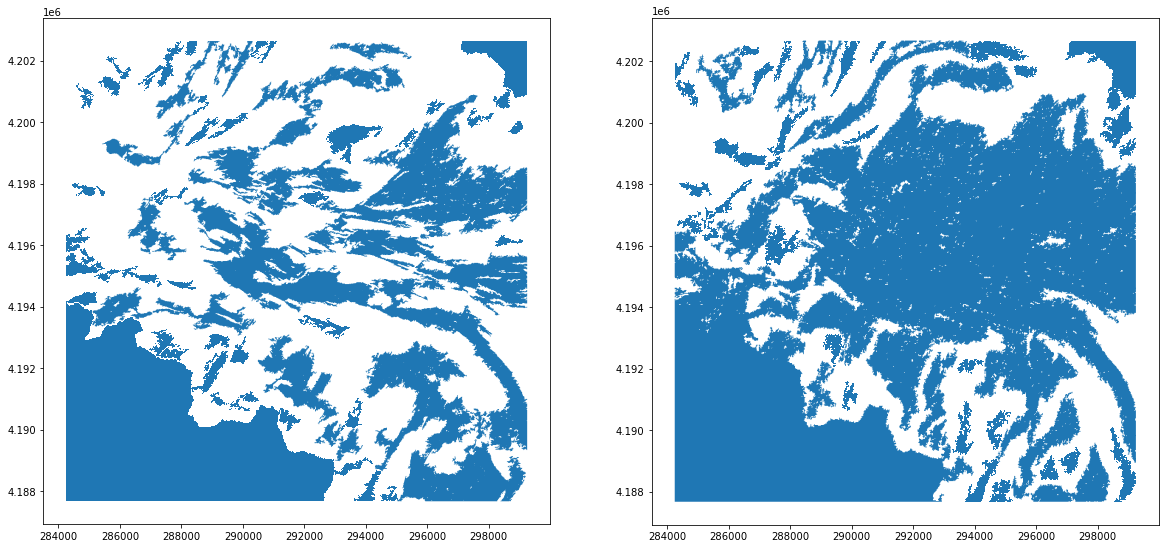

In [21]:
fig, ax = plt.subplots(ncols=2, figsize = (20, 10))

stdev_gdf.plot(ax=ax[0])
slp_gdf.plot(ax=ax[1]);

## Load in ICESat-2 Points (from the ATLAS instrument onboard the satellite) and Tuolumne Basin Outline

In [22]:
atlas_df = pd.read_csv('/Users/Hannah/Documents/Documents_Grad/Research/GDA_2021/ICESat-2_Snowdepth/summer_2020_difference.csv')
atlas_gdf = gpd.GeoDataFrame(atlas_df, crs='epsg:32611', geometry=gpd.points_from_xy(atlas_df.x, atlas_df.y))
tuol_basin = gpd.read_file('/Users/Hannah/Documents/Documents_Grad/Research/GDA_2021/ImageAnalysis/data/Tuolumne_Boundary.geojson')

<AxesSubplot:>

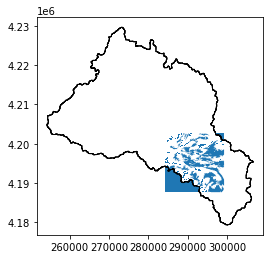

In [23]:
fig, ax = plt.subplots()
#atlas_gdf.plot(ax=ax)
stdev_gdf.plot(ax=ax)
tuol_basin.plot(ax=ax, facecolor='none', edgecolor='black')

## Buffer the Polygons to Make Sure They are Valid

In [25]:
stdev_gdf['geometry'] = stdev_gdf.buffer(0.01)

In [26]:
slp_gdf['geometry'] = slp_gdf.buffer(0.01)

### Clip the ICESat-2 Points to the Slope and Standard Deviation Polygons

In [27]:
atlas_gdf_clipped = gpd.clip(atlas_gdf, stdev_gdf, keep_geom_type=True)

In [28]:
atlas_gdf_clipped2 = gpd.clip(atlas_gdf_clipped, slp_gdf, keep_geom_type=True)

<AxesSubplot:>

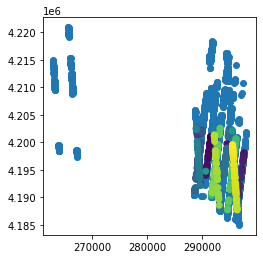

In [29]:
fig, ax = plt.subplots()

atlas_gdf.plot(ax=ax)
atlas_gdf_clipped.plot(cmap='viridis', ax=ax)

<AxesSubplot:>

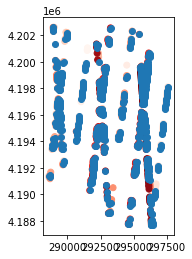

In [30]:
fig, ax = plt.subplots()

atlas_gdf_clipped.plot(cmap='Reds', ax=ax)
atlas_gdf_clipped2.plot(ax=ax)